In [1]:
import torch
import numpy as np
import torch.nn as nn
from math import pi

In [59]:
# make spiral data
# and split the dataset
# https://gist.github.com/45deg/e731d9e7f478de134def5668324c44c5
N = 300
noise_weight = 2.5 # it decides how the noisy dataset is
num_test = 300

theta = np.sqrt(np.random.rand(N))*2*pi # np.linspace(0,2*pi,100)

r_a = 2*theta + pi
data_a = np.array([np.cos(theta)*r_a, np.sin(theta)*r_a]).T
x_a = data_a + np.random.randn(N,2) * noise_weight

r_b = -2*theta - pi
data_b = np.array([np.cos(theta)*r_b, np.sin(theta)*r_b]).T
x_b = data_b + np.random.randn(N,2) * noise_weight

res_a = np.append(x_a, np.zeros((N,1)), axis=1)
res_b = np.append(x_b, np.ones((N,1)), axis=1)

res = np.append(res_a, res_b, axis=0)
np.random.shuffle(res)
datas = torch.tensor(res, dtype=torch.float32)
data_xy = datas[:-num_test, :2]
data_label= datas[:-num_test, -1]

# Use random label shuffle
# rand_perm = torch.randperm(len(data_label))
# data_label = data_label[rand_perm]

test_xy = datas[-num_test:, :2]
test_label = datas[-num_test:, -1]

In [37]:
import matplotlib.pyplot as plt
def visualize_decision_boundary(model, data, label):
  x_linspace = torch.linspace(min(data[:,0]), max(data[:,0]), steps=200)
  y_linspace = torch.linspace(min(data[:,1]), max(data[:,1]), steps=200)
  grid_x, grid_y = torch.meshgrid(x_linspace, y_linspace)
  grid_xy = torch.stack([grid_x, grid_y]).permute(1,2,0)
  grid_xy = grid_xy.view(-1, 2)
  value_by_grid = model(grid_xy)

  value_by_grid = value_by_grid.view(200, 200, 1)
  value_by_grid[value_by_grid<=0.5] = 0
  value_by_grid[value_by_grid>0.5] = 1

  plt.scatter(x=data[label[:,0]==0,0], y=data[label[:,0]==0,1])
  plt.scatter(x=data[label[:,0]==1,0], y=data[label[:,0]==1,1])

  plt.contourf(grid_x.detach().numpy(), grid_y.detach().numpy(), value_by_grid.detach().numpy().squeeze(), alpha=0.3)

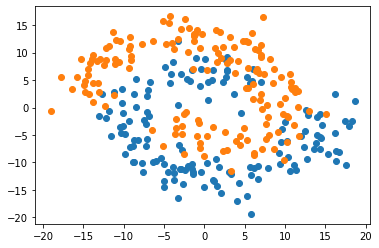

In [60]:
plt.scatter(x=data_xy[data_label==0,0], y=data_xy[data_label==0,1])
plt.scatter(x=data_xy[data_label==1,0], y=data_xy[data_label==1,1])

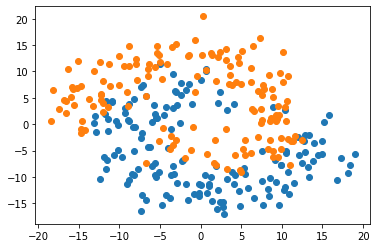

In [61]:
# Plot Test set
plt.scatter(x=test_xy[test_label==0,0], y=test_xy[test_label==0,1])
plt.scatter(x=test_xy[test_label==1,0], y=test_xy[test_label==1,1])

tensor(0.8633)


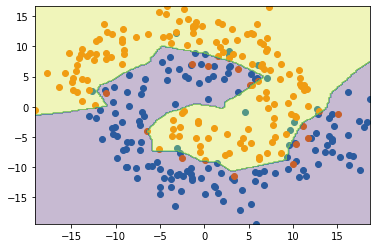

In [70]:
class MyModel(nn.Module):
  def __init__(self, hidden_size=32):
    super().__init__()
    self.layer = nn.Sequential(
        nn.Linear(2, hidden_size),
        nn.ReLU(),
        # nn.Sigmoid(),
        nn.Linear(hidden_size, hidden_size),
        nn.ReLU(), 
        # nn.Sigmoid(),       
        nn.Linear(hidden_size, hidden_size),
        nn.ReLU(),
        # nn.Sigmoid(),
        nn.Linear(hidden_size, 1)
    )
    # self.layer1 = nn.Linear(2, hidden_size) # this is same as in_features=2, out_features=4
    # self.layer2 = nn.Linear(hidden_size, hidden_size)
    # self.layer3 = nn.Linear(hidden_size, 1)

  def forward(self, input_x): 
    # forward function is called when you give input to your model
    # out = self.layer1(input_x)
    # pred = self.layer3(self.layer2(out.relu()).relu())

    # this will return the prediction of our model
    # which has shape of N, 1. (N is number of data samples in input_x)
    pred = self.layer(input_x)
    # pred = torch.sigmoid(pred)
    pred = pred.sigmoid()
    return pred

# Let's do the same things with torch.optim.Optimizer

hidden_size = 16 # hyperparameter
model = MyModel(hidden_size)
num_iteration = 500 # hyperparameter
lr = 1e-3 # 0.001 # hyperparameter
optimizer = torch.optim.Adam(model.parameters(), lr=lr)
# tell optimizer to optimize every parameters in the model

# save the loss record so that we can plot it
loss_record = []
binary_cross_entropy_fn = nn.BCELoss()

# let's train our model for a given number of steps
for i in range(num_iteration):
  pred = model(data_xy) # make prediction 
  # loss = torch.abs(pred[:,0]-data_label) # calculate loss for each sample
  # let' change loss function
  mean_loss = binary_cross_entropy_fn(pred[:,0], data_label)
  # mean_loss = loss.mean() # take average of loss of each sample
  # make backpropagation of loss
  mean_loss.backward() # this will add gradient for every parameters
  optimizer.step() # this will update every parameters in the optimizer (in the model)
  optimizer.zero_grad() # reset the gradient of every parameters in the optimizer
  loss_record.append(mean_loss.item())

visualize_decision_boundary(model, data_xy, data_label.unsqueeze(1))

test_pred = model(test_xy)
test_accuracy = get_accuracy(test_pred.squeeze(), test_label)
print(test_accuracy)

In [71]:
get_accuracy(pred.squeeze(), data_label)

tensor(0.9167)

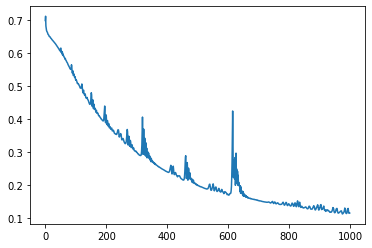

In [42]:
plt.plot(loss_record)

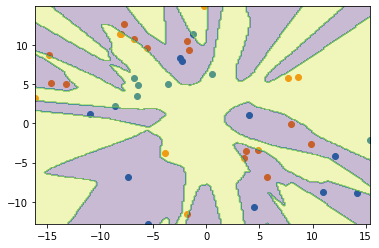

In [40]:
visualize_decision_boundary(model, test_xy, test_label.unsqueeze(1))

In [12]:
torch.set_printoptions(sci_mode=False)

In [58]:
# calculate the test accuracy
test_pred = model(test_xy)
# test_pred.shape, test_pred

# Convert the predicted probability into boolean value
# If the prediction is larger than 0.5,
# then convert it to 1

thresholded_pred = test_pred > 0.5
# thresholded_pred = torch.tensor(thresholded_pred, dtype=torch.long)
thresholded_pred = thresholded_pred[:, 0] # select last dim index 0 to squeeze
# it changes tensor's shape from [N, 1] to [N]
is_correct_pred = thresholded_pred == test_label
is_correct_pred
# get mean accuracy from is_correct_pred

correct_pred = 0
for value in is_correct_pred:
  if value == 1:
    correct_pred += 1
accuracy = correct_pred / len(is_correct_pred)
accuracy

0.9

In [32]:
# calculate the same value with a tensor method
accuracy = is_correct_pred.sum() / len(is_correct_pred)
accuracy = accuracy.item()
accuracy

0.949999988079071

In [43]:
def get_accuracy(pred, target):
  return ((pred > 0.5) == target).sum() / len(target)
get_accuracy(test_pred.squeeze(), test_label)

tensor(0.4500)

In [ ]:
torch.stack([thresholded_pred, test_label], dim=-1)